In [253]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [254]:
def loadData (flow, meta):
    df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
    df1.columns = ['ID', 'Year', 'Mnth', 'Day', 'Flow0', 'SYM']
    df1['datetime'] = pd.to_datetime(df1[['Year', 'Mnth', 'Day']].rename(columns={'Year': 'year', 'Mnth': 'month', 'Day': 'day'}))
    df1.drop(['ID', 'Year', 'Mnth', 'Day'], axis=1, inplace=True)
    df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)
    df = pd.concat([df1, df2], axis=1)
    df = pd.get_dummies(df, columns=['SYM'], dummy_na=True)
    df.set_index('datetime', inplace=True)
    df.drop(['Hr'], axis=1, inplace=True)
    before = 3
    after = 3
    # for i in range(1, before + 1):
    #     df[f'Flow-{i}'] = df['Flow0'].shift(+i)  # Shift down by 1   
    for i in  range(1, after + 1):
        df[f'Flow+{i}'] = df['Flow0'].shift(-i)  # Shift up by 1   
    df = df.dropna()
    return df

In [255]:
def expand_mean(df):
    return df.expanding(1).mean()
def pct_diff(old, new):
    return (new-old) / old
def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"

    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df

# rolling_horizons = [3, 7]

# for horizon in rolling_horizons:
#     for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
#         df = compute_rolling(df, horizon, col)

# df = df.fillna(0)

# for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
#     df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
#     df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

In [256]:
def CAMELSrun(data_id, horizon1, horizon2, target_var, SYM_M):
    df = loadData(f'Data/Idaho/{data_id}_streamflow_qc.txt', f'Data/Idaho/{data_id}_lump_maurer_forcing_leap.txt')
    rolling_horizons = [horizon1, horizon2]

    for horizon in rolling_horizons:
        for col in ['prcp(mm/day)', 'srad(W/m2)', 'Flow0', 'tmax(C)', 'tmin(C)', 'vp(Pa)']:
            df = compute_rolling(df, horizon, col)

    df = df.fillna(0)

    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        df[f'month_avg_{col}'] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
        df[f'day_avg_{col}'] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)

    # List of features to drop based on importance scores
    features_to_drop = [
        'SYM_A', 'SYM_A:e', 'SYM_nan', 'swe(mm)',
        'Year', 'Day', 
        # 'tmax(C)', 'tmin(C)', 
        # 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
        # 'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct',
        # 'rolling_3_tmax(C)',
        # 'rolling_7_prcp(mm/day)', 'rolling_7_prcp(mm/day)_pct', 
        # 'rolling_7_tmax(C)', 'rolling_7_tmax(C)_pct',
        # 'rolling_7_tmin(C)_pct', 'rolling_7_vp(Pa)', 
        # 'rolling_14_srad(W/m2)_pct',
        # 'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 
        # 'rolling_14_prcp(mm/day)', 'rolling_14_srad(W/m2)', 
        # 'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct',
        # 'month_avg_vp(Pa)',
        # 'month_avg_tmax(C)',
        # 'month_avg_prcp(mm/day)',
        # 'month_avg_srad(W/m2)'
        # 'day_avg_vp(Pa)',
    ]

    if SYM_M:
        features_to_drop.append('SYM_M')
    # Drop the features from the DataFrame
    df = df.drop(columns=features_to_drop)

    Y = df[f'{target_var}']  # Target variable
    adjX = df.drop(['Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
    X = adjX.columns

    return df, X, Y

In [257]:
def visualization(datetime, y_pred, y_test, zoom_start, zoom_end):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    accuracy = 100 - np.mean(mape)
    r2 = r2_score(y_test, y_pred)
    
    print(f"MAE: {round(mae, 2)} m3/s")
    print(f"MSE: {round(mse, 2)} m3/s")
    print(f"RMSE: {round(np.sqrt(mse), 2)} m3/s")
    print(f"MAPE: {round(mape, 2)}%")
    print(f"Accuracy: {round(accuracy, 3)}%")
    print(f"R2: {round(r2, 4)}")
    
    # Plot Actual vs Predicted Streamflow Values
    plt.figure(figsize=(14, 8))
    plt.plot(datetime, y_test, label='Actual Flow', color='black')
    plt.plot(datetime, y_pred, label='Predicted Flow', linestyle='--', color='C0')
    plt.xlabel('Datetime')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Zoomed in Plot
    plt.figure(figsize=(14, 8))
    plt.plot(datetime, y_test, label='Actual Flow', color='black')
    plt.plot(datetime, y_pred, label='Predicted Flow', color='C0')
    plt.xlabel('Datetime')
    plt.ylabel('Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Values (Zoomed)')
    
    # Set the x and y limits to zoom in
    plt.xlim(datetime[zoom_start], datetime[zoom_end])
    plt.ylim(min(y_test[zoom_start:zoom_end].min(), y_pred[zoom_start:zoom_end].min()), 
             max(y_test[zoom_start:zoom_end].max(), y_pred[zoom_start:zoom_end].max()))
    
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Residuals Plot
    plt.figure(figsize=(14, 8))
    residuals = y_test - y_pred
    plt.plot(datetime, residuals, label='Residuals Flow+0')
    plt.axhline(0, color='black', linestyle='--')
    plt.xlabel('Datetime')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residuals for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residuals Scatter Plot
    plt.figure(figsize=(14, 8))
    plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals for Flow+0')
    plt.axhline(0, color='black', linestyle='--', label='Zero Residual Line')
    plt.xlabel('Predicted Streamflow (m3/s)')
    plt.ylabel('Residual (m3/s)')
    plt.title('Residual Scatter Plot for Each Day Ahead Prediction')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Actual vs Predicted Scatter Plot
    plt.figure(figsize=(14, 8))
    plt.scatter(y_test, y_pred, label='Flow+0', alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Streamflow (m3/s)')
    plt.ylabel('Predicted Streamflow (m3/s)')
    plt.title('Actual vs Predicted Streamflow Scatter Plot')
    plt.legend()
    plt.grid(True)
    plt.show()


In [258]:
# df = loadData('Data/Idaho/13340000_streamflow_qc.txt', 'Data/Idaho/13340000_lump_maurer_forcing_leap.txt')


In [259]:
# # List of features to drop based on importance scores
# features_to_drop = [
#     'SYM_A', 'SYM_A:e', 'SYM_nan', 'swe(mm)',
#     'Year', 'Day', 
#     # 'tmax(C)', 'tmin(C)', 
#     # 'rolling_3_prcp(mm/day)', 'rolling_3_srad(W/m2)_pct',
#     # 'rolling_3_tmax(C)_pct', 'rolling_3_tmin(C)_pct',
#     # 'rolling_3_tmax(C)',
#     # 'rolling_7_prcp(mm/day)', 'rolling_7_prcp(mm/day)_pct', 
#     # 'rolling_7_tmax(C)', 'rolling_7_tmax(C)_pct',
#     # 'rolling_7_tmin(C)_pct', 'rolling_7_vp(Pa)', 
#     # 'rolling_14_srad(W/m2)_pct',
#     # 'rolling_14_tmax(C)', 'rolling_14_tmin(C)', 
#     # 'rolling_14_prcp(mm/day)', 'rolling_14_srad(W/m2)', 
#     # 'rolling_14_tmax(C)_pct', 'rolling_14_tmin(C)_pct',
#     # 'month_avg_vp(Pa)',
#     # 'month_avg_tmax(C)',
#     # 'month_avg_prcp(mm/day)',
#     # 'month_avg_srad(W/m2)'
#     # 'day_avg_vp(Pa)',
# ]

# # Drop the features from the DataFrame
# df = df.drop(columns=features_to_drop)


In [260]:
# Y = df['Flow+1']  # Target variable
# adjX = df.drop(['Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X = adjX.columns

In [261]:
model = keras.Sequential([
            Dense(64, activation='relu', input_shape=(44,), kernel_regularizer='l2'),
            Dropout(0.1),
            Dense(32, activation='relu', kernel_regularizer='l2'),
            Dropout(0.1),
            Dense(1)])

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])


# Summary to see the architecture
model.summary()


c:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_45 (Dense)                │ (None, 64)             │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,993 (19.50 KB)

 Trainable params: 4,993 (19.50 KB)

 Non-trainable params: 0 (0.00 B)

In [270]:
def print_model_weights_and_biases(model):
    for layer_idx, layer in enumerate(model.layers):
        weights = layer.get_weights()  # Returns a list: [weights, biases]
        print(f"Layer {layer_idx+1}: {layer.name}")
        
        if len(weights) > 0:  # Some layers (like Dropout) may not have weights
            print(f"  Weights shape: {weights[0].shape}")
            print(f"  Weights: {weights[0]}")
            
            if len(weights) > 1:  # If biases exist
                print(f"  Biases shape: {weights[1].shape}")
                print(f"  Biases: {weights[1]}")
        else:
            print("  No weights/biases for this layer.")

In [262]:
def permutation_importance(model, X_test, y_test, metric=mean_squared_error):
    baseline_score = metric(y_test, model.predict(X_test))
    importances = []
    
    for i in range(X_test.shape[1]):
        X_test_permuted = X_test.copy()
        np.random.shuffle(X_test_permuted[:, i])
        permuted_score = metric(y_test, model.predict(X_test_permuted))
        importances.append(permuted_score - baseline_score)
    
    return np.array(importances)

In [263]:
def backtest(df, model, X, Y, train_window_size=1195, test_window_size=60):
    all_predictions = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()

    # Y = np.log1p(Y)

    if isinstance(Y, pd.Series):
        Y_column = Y.name
    else:
        Y_column = Y

    # train_window_size = 540  # For example, 540 periods for training
    test_indices = []

    for i in range(0, df.shape[0] - train_window_size - test_window_size + 1, test_window_size):
        train = df.iloc[i:(i+train_window_size), :]
        test = df.iloc[(i+train_window_size):(i+train_window_size+test_window_size), :]
        
        test_indices.extend(test.index)

        X_train = train[X]
        X_train = scaler_X.fit_transform(X_train)

        X_test = test[X]
        X_test = scaler_X.transform(test[X])
        
        # Y_train = np.log1p(train[[Y_column]])
        Y_train = train[[Y_column]]
        Y_train = scaler_Y.fit_transform(Y_train).reshape(-1, 1) 

        # Y_test = np.log1p(test[[Y_column]])
        Y_test = test[[Y_column]]
        Y_test = scaler_Y.transform(Y_test).reshape(-1, 1) 

        model.fit(X_train, Y_train, epochs=15, verbose=1, validation_split=0.2, callbacks=[early_stopping])

        preds = model.predict(X_test)

        preds = scaler_Y.inverse_transform(preds).reshape(-1, 1).flatten() 
        Y_test = scaler_Y.inverse_transform(Y_test).reshape(-1, 1).flatten()

        # preds = np.expm1(preds)  # Reverse the log1p transformation.
        # Y_test = np.expm1(Y_test)  # Reverse the log1p transformation for the test data as well.

        combined = pd.DataFrame({
            "actual": Y_test,
            "prediction": preds
        }, index=test.index)

        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_predictions.append(combined)

    all_predictions = pd.concat(all_predictions, axis=0)

    # Create a datetime index for all test predictions
    datetime = pd.Index(test_indices)

    return all_predictions, datetime


In [264]:
df, X, Y = CAMELSrun('04045500', 3, 7, 'Flow0', True)

C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_15512\2706607532.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
C:\Users\Abdullah Usmani\AppData\Local\Temp\ipykernel_15512\2706607532.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [265]:

predictions, datetime1 = backtest(df, model, X, Y)
y_pred = predictions["prediction"]
y_test = predictions["actual"]

y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
y_pred = np.minimum(y_pred, np.max(y_test) * 1.1)  # Cap predictions at 10% above max value of y_test

Epoch 1/15


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.0344 - mean_squared_error: 1.1022 - val_loss: 1.1657 - val_mean_squared_error: 0.2769
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1533 - mean_squared_error: 0.2799 - val_loss: 1.0198 - val_mean_squared_error: 0.1939
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9540 - mean_squared_error: 0.1442 - val_loss: 0.9082 - val_mean_squared_error: 0.1465
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8350 - mean_squared_error: 0.0885 - val_loss: 0.8351 - val_mean_squared_error: 0.1348
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7693 - mean_squared_error: 0.0836 - val_loss: 0.7610 - val_mean_squared_error: 0.1185
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7063 - mean_squared_error: 0.0774 - val_loss: 0.7031 - val_mean_squared_error: 0.1140
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6374 - mean_squared_error: 0.0609 - val_loss: 0.6374 - val_mean_squared_err

MAE: 48.29 m3/s
MSE: 23667.23 m3/s
RMSE: 153.84 m3/s
MAPE: 0.09%
Accuracy: 99.911%
R2: 0.9667


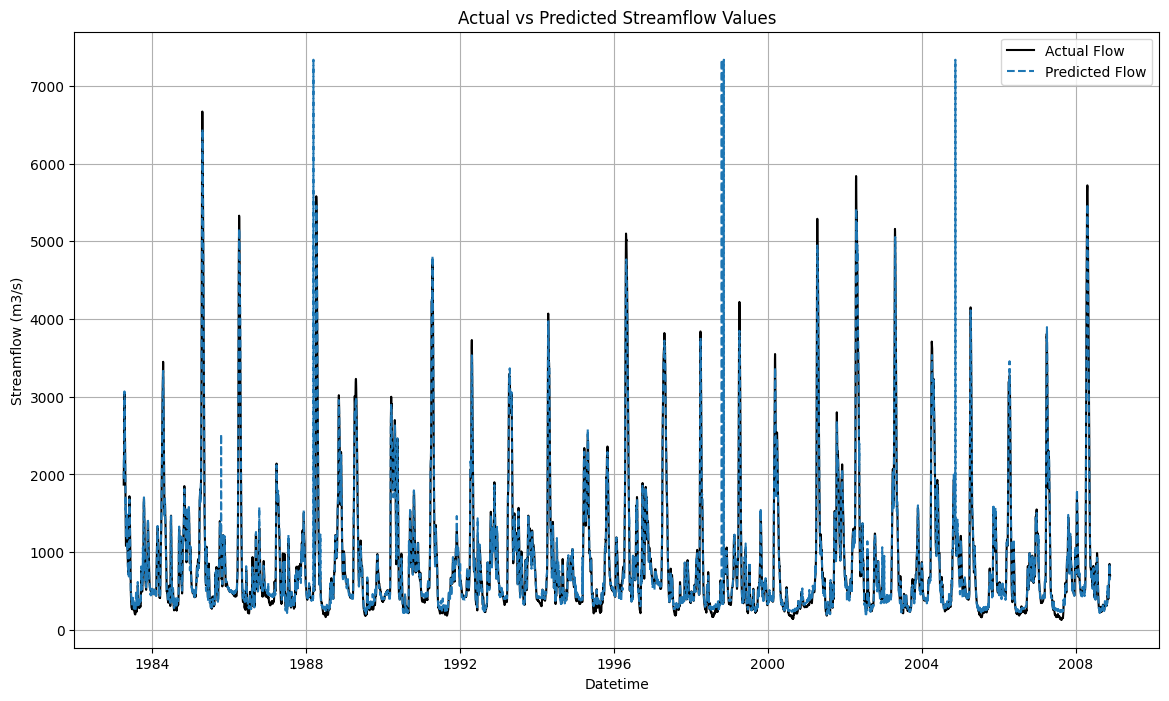

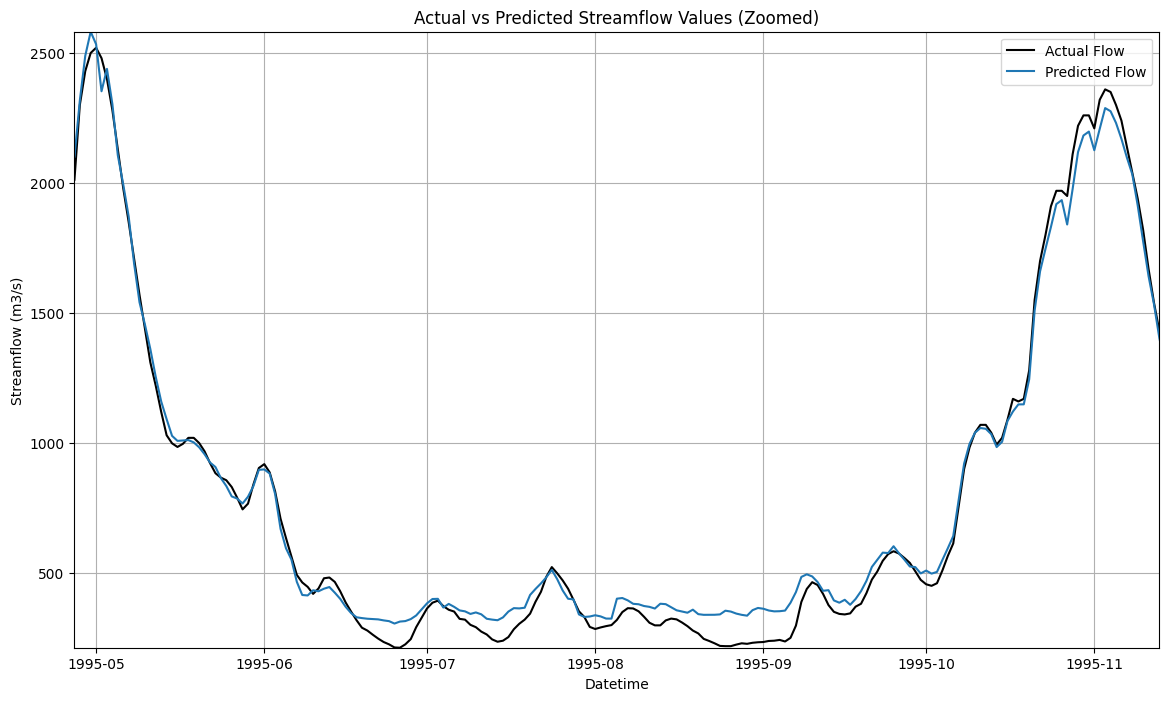

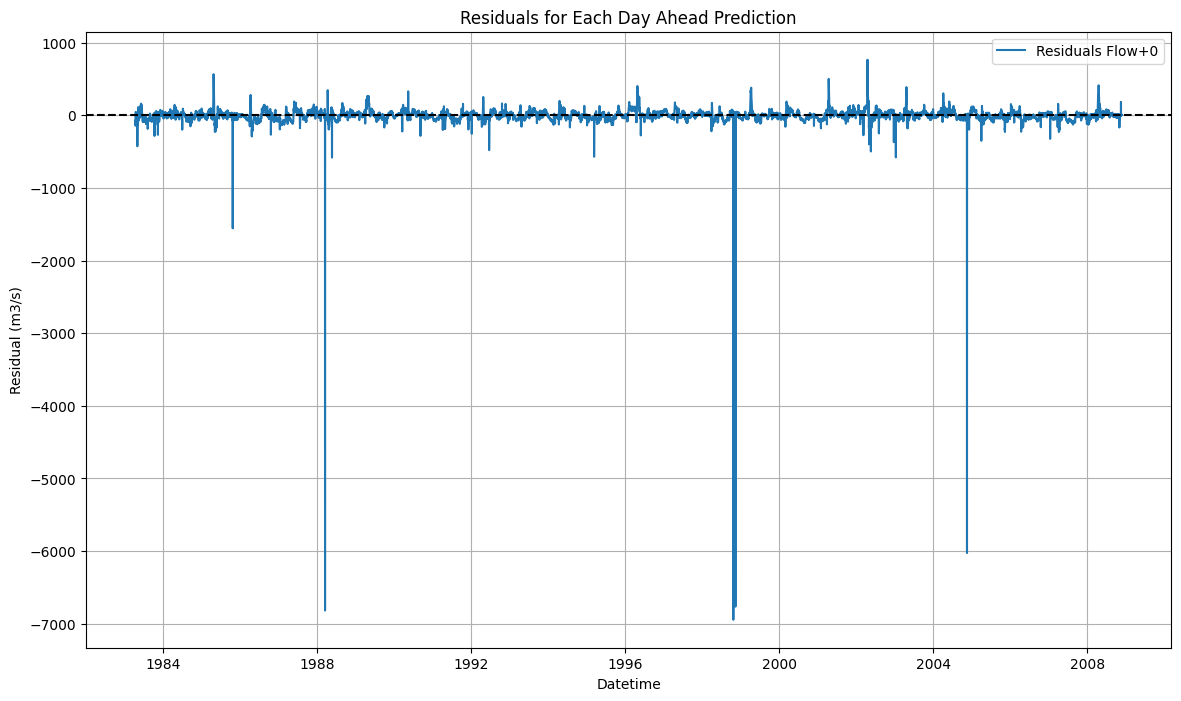

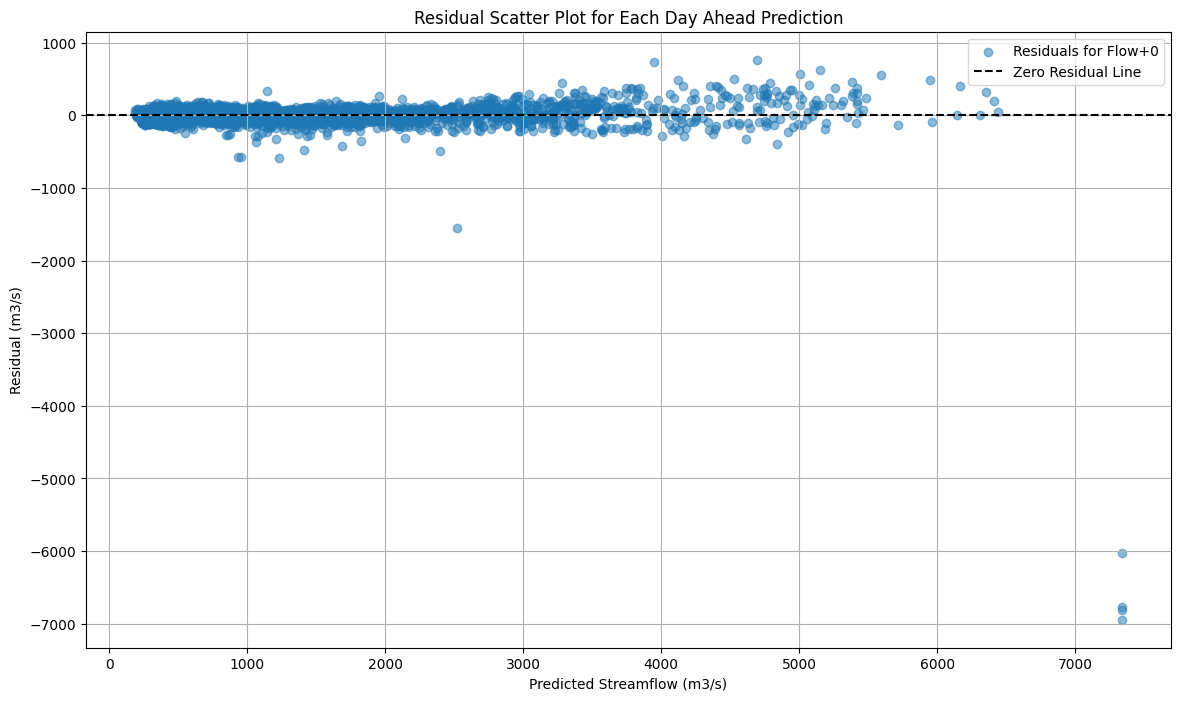

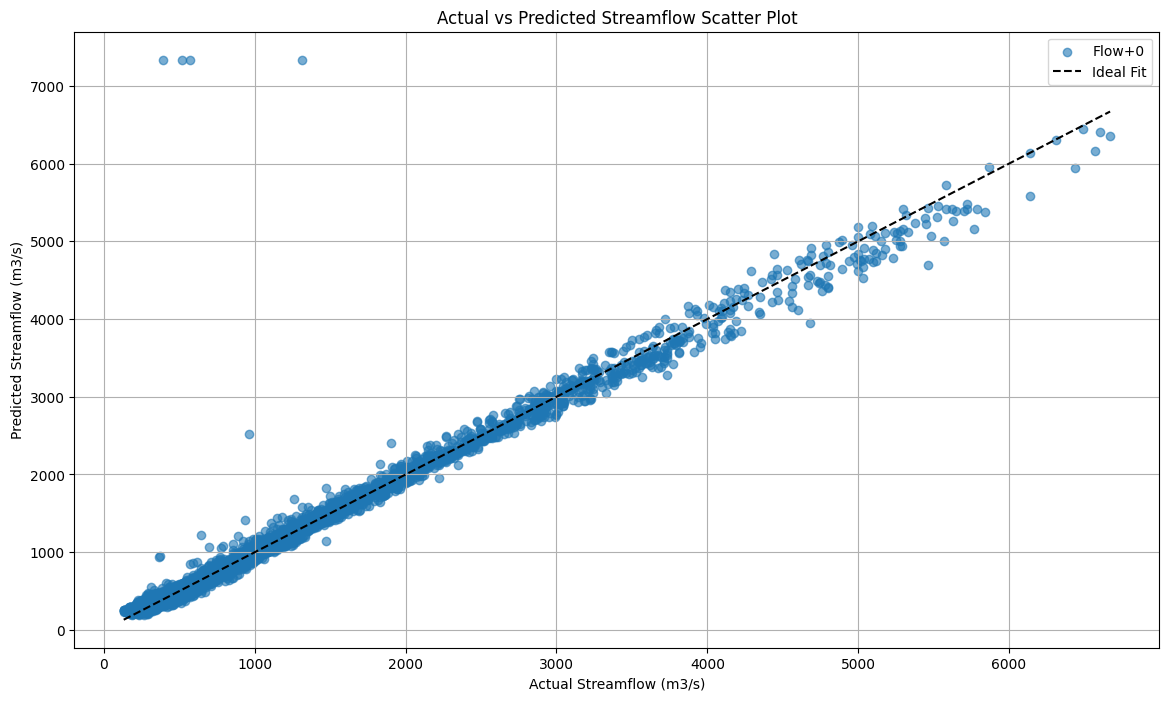

In [266]:
visualization(datetime1, y_pred, y_test, 4400, 4600)
print_model_weights_and_biases(model)

In [268]:
predictions1, datetime2 = backtest(df, model, X, Y)

y_pred1 = predictions1["prediction"]
y_test1 = predictions1["actual"]

y_pred1 = np.maximum(y_pred1, 0)  # Ensure no negative predictions1
y_pred1 = np.minimum(y_pred1, np.max(y_test1) * 1.1)  # Cap predictions1 at 10% above max value of y_test

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0266 - mean_squared_error: 0.0188 - val_loss: 0.0112 - val_mean_squared_error: 0.0033
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0322 - mean_squared_error: 0.0244 - val_loss: 0.0096 - val_mean_squared_error: 0.0018
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335 - mean_squared_error: 0.0257 - val_loss: 0.0107 - val_mean_squared_error: 0.0027
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0277 - mean_squared_error: 0.0196 - val_loss: 0.0104 - val_mean_squared_error: 0.0022
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - mean_squared_error: 0.0193 - val_loss: 0.0107 - val_mean_squared_error: 0.0026
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0279 - mean_squared_error: 0.0198 - val_loss: 0.0104 - val_mean_squared_error: 0.0020
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0339 - mean_squared_error:

MAE: 583.23 m3/s
MSE: 3645204.03 m3/s
RMSE: 1909.24 m3/s
MAPE: 0.17%
Accuracy: 99.835%
R2: 0.9646


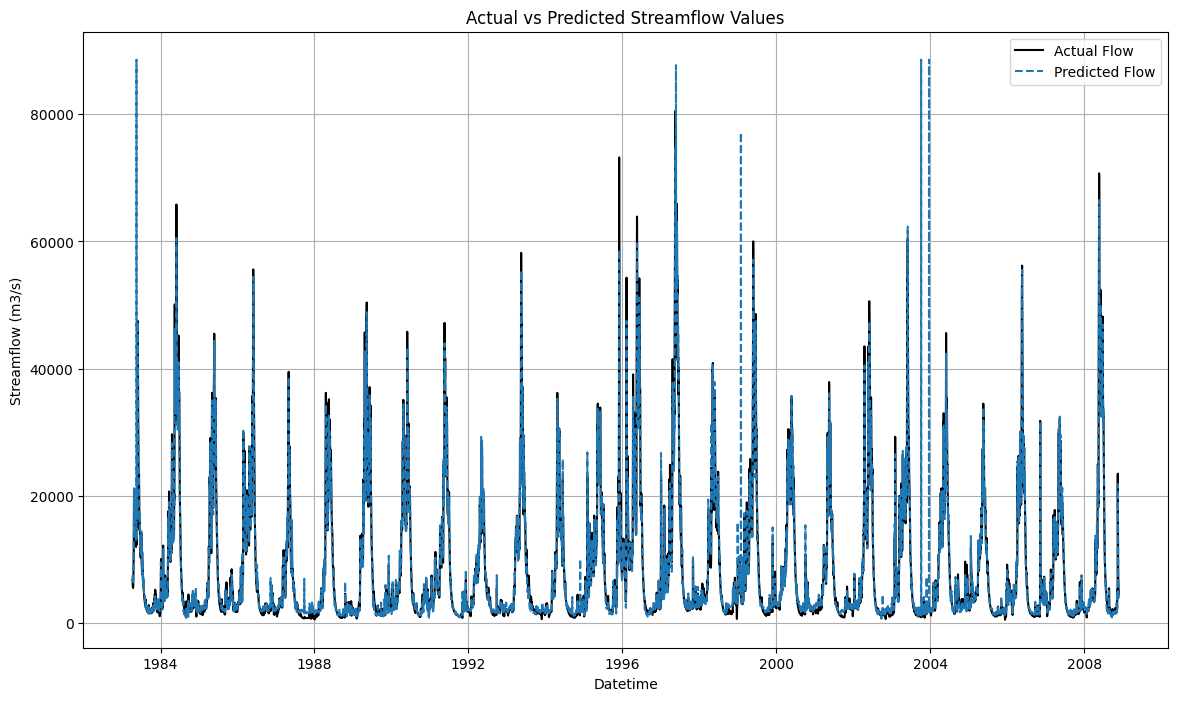

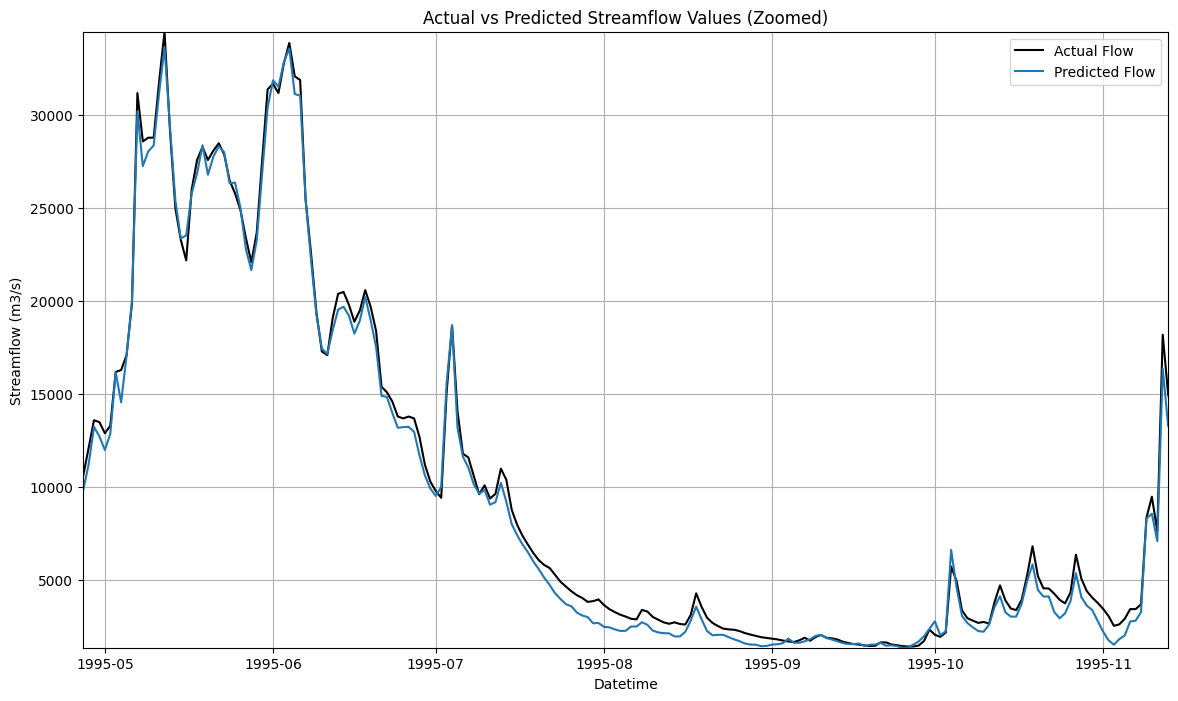

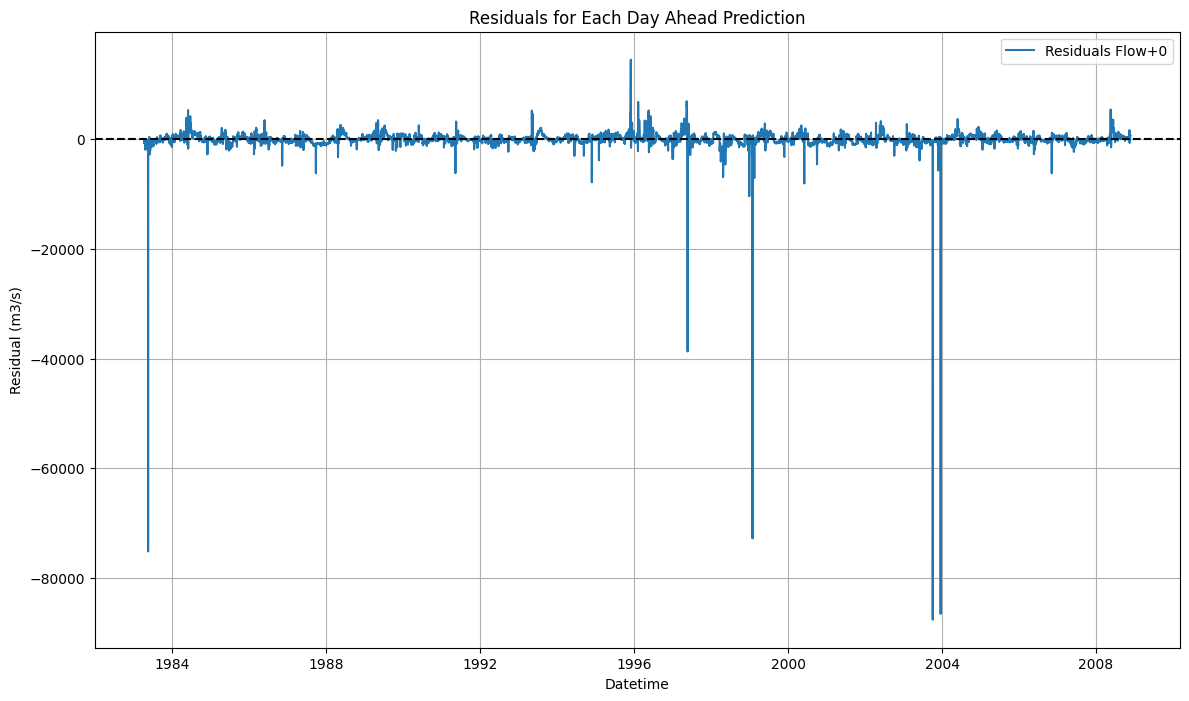

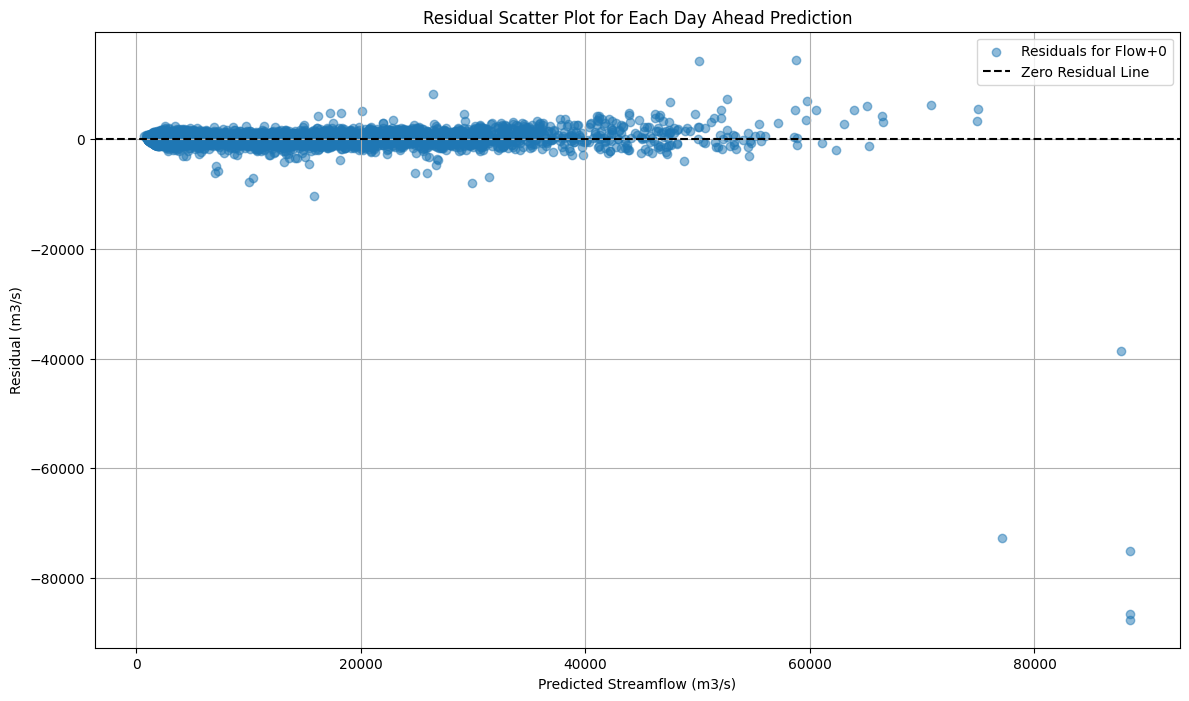

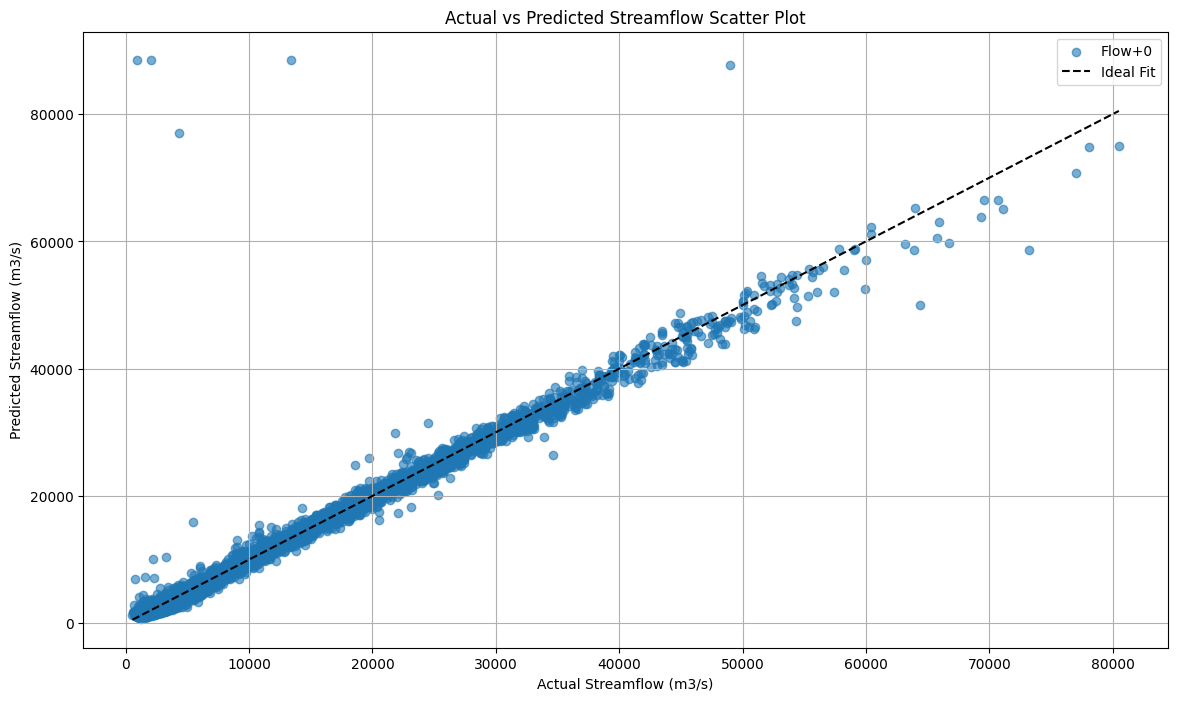

Layer 1: dense_45
  Weights shape: (44, 64)
  Weights: [[-5.7042764e-34 -5.4912351e-34 -2.8942195e-34 ...  9.0527982e-02
   9.1355778e-02  1.8999441e-34]
 [ 5.1379577e-34  2.2120030e-34 -3.0848360e-34 ... -1.2247900e-02
  -3.0113412e-03  1.1652278e-34]
 [-9.9854744e-35  1.5394389e-34 -2.3656238e-34 ...  4.9451063e-03
   5.2189878e-03 -5.0628849e-34]
 ...
 [-1.8756957e-34  1.3355475e-34 -6.6031650e-35 ... -4.6924865e-03
  -1.3930800e-03 -4.6245936e-34]
 [-2.2834623e-34  4.5383380e-34  3.6895485e-34 ... -1.6116176e-03
   1.9769066e-03 -3.5786461e-34]
 [ 1.7998839e-34  1.2186941e-34  4.8004370e-34 ... -8.7923994e-03
  -3.2067599e-03  5.8464514e-35]]
  Biases shape: (64,)
  Biases: [-0.05581079 -0.02307541 -0.01733723  0.11558326 -0.00962989 -0.01116434
 -0.00804338 -0.04057286 -0.0141362  -0.01945451 -0.00332269 -0.00985338
 -0.24883683 -0.00210257  0.13396555 -0.0043787  -0.00478388 -0.00726482
 -0.1567033   0.12843634 -0.00647099  0.00178869 -0.00207249  0.12289541
  0.1259815  -0.32588

In [271]:
visualization(datetime2, y_pred1, y_test1, 4400, 4600)
print_model_weights_and_biases(model)

new_df = loadData('Data/Idaho/05131500_streamflow_qc.txt', 'Data/Idaho/05131500_lump_maurer_forcing_leap.txt')

rolling_horizons = [3, 7]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)


# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)

Y_new = new_df['Flow+1']  # Target variable
X_new = new_df.drop(['Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
X_new = X_new.columns



predictions_new, scaler_X, scaler_Y, datetime2 = backtest(new_df, model, X_new, Y_new)

# X_new = scaler_X.transform(X_new)
# # Y_new = scaler_Y.transform(Y_new)

# # Step 3: Make predictions
# predictions_new = model.predict(X_new)

# # If needed, inverse transform predictions_new
# predictions_new = scaler_Y.inverse_transform(predictions_new)

# # Step 4: Create a DataFrame to store the results
# results = pd.DataFrame(predictions_new, columns=['Predictions'], index=new_df.index)

# # Optional: Add the actual target values if available
# results['Actual'] = Y_new
y_pred_new1 = predictions_new["prediction"]
y_test_new1 = predictions_new["actual"]
y_pred_new1 = np.maximum(y_pred_new1, 0)  # Ensure no negative predictions
y_pred_new1 = np.minimum(y_pred_new1, np.max(y_test_new1) * 1.10)  # Cap predictions at 10% above max value of y_test



visualization(datetime2, y_pred_new1, y_test_new1, 1400, 1600)

new_df = loadData('Data/Idaho/04045500_streamflow_qc.txt', 'Data/Idaho/04045500_lump_maurer_forcing_leap.txt')
new_df = new_df.drop(['SYM_M'], axis=1)
rolling_horizons = [3, 7]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)


# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)

Y_new = new_df[['Flow+1']]  # Target variable
X_new = new_df.drop(['Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X_new = X_new.columns

# predictions_new, scaler_X, scaler_Y = backtest(new_df, model, X_new, Y_new)

X_new = scaler_X.transform(X_new)
# Y_new = np.log1p(Y_new)
# Y_new = scaler_Y.transform(Y_new)

# Step 3: Make predictions
predictions_new = model.predict(X_new)

# If needed, inverse transform predictions_new
predictions_new = scaler_Y.inverse_transform(predictions_new)
predictions_new = y_pred = np.expm1(predictions_new)

# Step 4: Create a DataFrame to store the results
results = pd.DataFrame(predictions_new, columns=['Predictions'], index=new_df.index)

# Optional: Add the actual target values if available
results['Actual'] = Y_new

y_pred_new2 = results["Predictions"]
y_test_new2 = results["Actual"]

# y_pred_new2 = predictions_new["prediction"]
# y_test_new2 = predictions_new["actual"]
y_pred_new2 = np.maximum(y_pred_new2, 0)  # Ensure no negative predictions
y_pred_new2 = np.minimum(y_pred_new2, np.max(y_test_new2) * 1.10)  # Cap predictions at 10% above max value of y_test


visualization(Y_new.index, y_pred_new2, y_test_new2, 4200, 4600)

new_df = loadData('Data/Idaho/02464000_streamflow_qc.txt', 'Data/Idaho/02464000_lump_maurer_forcing_leap.txt')
rolling_horizons = [3, 7]

for horizon in rolling_horizons:
    for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
        new_df = compute_rolling(new_df, horizon, col)

new_df = new_df.fillna(0)

for col in ['prcp(mm/day)', 'srad(W/m2)', 'tmax(C)', 'Flow0', 'tmin(C)', 'vp(Pa)']:
    new_df[f'month_avg_{col}'] = new_df[col].groupby(new_df.index.month, group_keys=False).apply(expand_mean)
    new_df[f'day_avg_{col}'] = new_df[col].groupby(new_df.index.day_of_year, group_keys=False).apply(expand_mean)

# Drop the features from the DataFrame
new_df = new_df.drop(columns=features_to_drop)



Y_new = new_df[['Flow+1']]  # Target variable
X_new = new_df.drop(['Flow+1', 'Flow+2', 'Flow+3'], axis=1)  # Features
# X_new = X_new.columns

svr_linear = SVR(kernel='rbf', C=10, epsilon=0.00001)

predictions_new, scaler_X, scaler_Y, datetime2 = backtest(new_df, svr_linear, X_new, Y_new)

y_pred_new1 = predictions_new["prediction"]
y_test_new1 = predictions_new["actual"]
y_pred_new1 = np.maximum(y_pred_new1, 0)  # Ensure no negative predictions
y_pred_new1 = np.minimum(y_pred_new1, np.max(y_test_new1) * 1.10)  # Cap predictions at 10% above max value of y_test